In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

full_dataset = datasets.ImageFolder("../../data", transform=transform)
keep = {"Forest","Residential"}
keep_idx = [i for i,(_,y) in enumerate(full_dataset) if full_dataset.classes[y] in keep]
subset = Subset(full_dataset, keep_idx)

class_map = {full_dataset.class_to_idx["Forest"]:0, full_dataset.class_to_idx["Residential"]:1}

class Relabeled(Dataset):
    def __init__(self, subset, m): self.subset, self.m = subset, m
    def __len__(self): return len(self.subset)
    def __getitem__(self, i):
        x,y = self.subset[i]
        return x, self.m[y]

dataset = Relabeled(subset, class_map)

train_size = int(0.8*len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=0)


In [3]:
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1), nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1), nn.BatchNorm2d(out_c), nn.ReLU(inplace=True)
        )
    def forward(self,x): return self.net(x)

class Down(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = DoubleConv(in_c, out_c)
    def forward(self,x): return self.conv(self.pool(x))

class Up(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, 2, stride=2)
        self.conv = DoubleConv(in_c, out_c)
    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

class UNetMTL(nn.Module):
    def __init__(self):
        super().__init__()
        self.inc  = DoubleConv(3, 32)
        self.down1= Down(32, 64)
        self.down2= Down(64,128)
        self.down3= Down(128,256)
        self.up1  = Up(256,128)
        self.up2  = Up(128, 64)
        self.up3  = Up( 64, 32)
        self.outc = nn.Conv2d(32, 3, 1)
        self.head = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Dropout(0.5), nn.Linear(256,2))
    def forward(self,x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        logits = self.head(x4)
        y = self.up1(x4, x3)
        y = self.up2(y,  x2)
        y = self.up3(y,  x1)
        recon = torch.tanh(self.outc(y))
        return logits, recon


In [4]:
def train_mtl(model, train_loader, val_loader, lr=1e-3, epochs=30, alpha=0.5, patience=5):
    ce = nn.CrossEntropyLoss()
    mse = nn.MSELoss()
    opt = optim.Adam(model.parameters(), lr=lr)
    best, wait = float("inf"), 0
    hist = {"train_loss":[], "val_loss":[], "val_acc":[]}
    for ep in range(epochs):
        model.train()
        s = 0.0
        for x,y in train_loader:
            x,y = x.to(device), y.to(device)
            opt.zero_grad()
            logits, recon = model(x)
            loss = alpha*ce(logits,y) + (1-alpha)*mse(recon,x)
            loss.backward()
            opt.step()
            s += loss.item()*x.size(0)
        tr_loss = s/len(train_loader.dataset)
        model.eval()
        vs, ok, tot = 0.0, 0, 0
        with torch.no_grad():
            for x,y in val_loader:
                x,y = x.to(device), y.to(device)
                logits, recon = model(x)
                loss = alpha*ce(logits,y) + (1-alpha)*mse(recon,x)
                vs += loss.item()*x.size(0)
                pred = logits.argmax(1)
                ok += (pred==y).sum().item()
                tot += y.size(0)
        vl = vs/len(val_loader.dataset)
        va = ok/tot
        hist["train_loss"].append(tr_loss); hist["val_loss"].append(vl); hist["val_acc"].append(va)
        print(f"Epoch {ep+1}/{epochs} | Train {tr_loss:.4f} | Val {vl:.4f} | Acc {va:.4f}")
        if vl<best:
            best, wait = vl, 0
            best_w = model.state_dict()
        else:
            wait += 1
            if wait>=patience:
                print("Early stopping")
                break
    model.load_state_dict(best_w)
    return model, hist

model = UNetMTL().to(device)
model, hist = train_mtl(model, train_loader, val_loader, lr=1e-3, epochs=30, alpha=0.4, patience=6)


Epoch 1/30 | Train 0.0317 | Val 0.0086 | Acc 0.9983
Epoch 2/30 | Train 0.0185 | Val 0.0072 | Acc 0.9967
Epoch 3/30 | Train 0.0077 | Val 0.0147 | Acc 0.9917
Epoch 4/30 | Train 0.0088 | Val 0.0020 | Acc 1.0000
Epoch 5/30 | Train 0.0068 | Val 0.0029 | Acc 0.9975
Epoch 6/30 | Train 0.0034 | Val 0.0020 | Acc 0.9992
Epoch 7/30 | Train 0.0166 | Val 0.0022 | Acc 1.0000
Epoch 8/30 | Train 0.0035 | Val 0.0009 | Acc 1.0000
Epoch 9/30 | Train 0.0030 | Val 0.0007 | Acc 1.0000
Epoch 10/30 | Train 0.0050 | Val 0.0206 | Acc 0.9917
Epoch 11/30 | Train 0.0061 | Val 0.0024 | Acc 0.9983
Epoch 12/30 | Train 0.0020 | Val 0.0009 | Acc 1.0000
Epoch 13/30 | Train 0.0019 | Val 0.0282 | Acc 0.9800
Epoch 14/30 | Train 0.0021 | Val 0.0007 | Acc 1.0000
Epoch 15/30 | Train 0.0026 | Val 0.0008 | Acc 1.0000
Early stopping


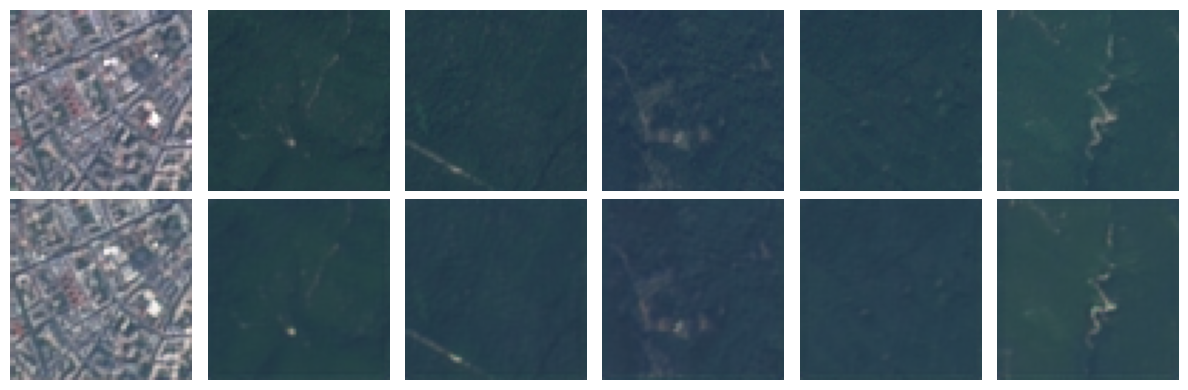

In [5]:
def show_recon(model, loader, n=6):
    model.eval()
    x,_ = next(iter(loader))
    x = x[:n].to(device)
    with torch.no_grad():
        _, r = model(x)
    x = (x.cpu().permute(0,2,3,1)*0.5+0.5).clamp(0,1)
    r = (r.cpu().permute(0,2,3,1)*0.5+0.5).clamp(0,1)
    plt.figure(figsize=(12,4))
    for i in range(n):
        plt.subplot(2,n,i+1); plt.imshow(x[i]); plt.axis("off")
        plt.subplot(2,n,i+1+n); plt.imshow(r[i]); plt.axis("off")
    plt.tight_layout(); plt.show()

show_recon(model, val_loader, n=6)


In [7]:
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, Subset, DataLoader
import torch

ood_base = ImageFolder("../../data/OOD", transform=transform)
orig_to_new = {
    ood_base.class_to_idx["Forest"]: 0,
    ood_base.class_to_idx["DenseResidential"]: 1,
    ood_base.class_to_idx["MediumResidential"]: 1,
}

class RelabeledDataset(Dataset):
    def __init__(self, base, mapping):
        self.base = base
        self.mapping = mapping
    def __len__(self):
        return len(self.base)
    def __getitem__(self, idx):
        x, y = self.base[idx]
        return x, self.mapping[y]

rel_ood = RelabeledDataset(ood_base, orig_to_new)

idx_dense  = [i for i,(_,y) in enumerate(ood_base.samples) if y == ood_base.class_to_idx["DenseResidential"]]
idx_medium = [i for i,(_,y) in enumerate(ood_base.samples) if y == ood_base.class_to_idx["MediumResidential"]]
idx_forest = [i for i,(_,y) in enumerate(ood_base.samples) if y == ood_base.class_to_idx["Forest"]]

ood_loader     = DataLoader(rel_ood, batch_size=64, shuffle=False)
dense_loader   = DataLoader(Subset(rel_ood, idx_dense),  batch_size=64, shuffle=False)
medium_loader  = DataLoader(Subset(rel_ood, idx_medium), batch_size=64, shuffle=False)
forest_loader  = DataLoader(Subset(rel_ood, idx_forest), batch_size=64, shuffle=False)

len(ood_base), len(idx_forest), len(idx_dense), len(idx_medium)


(120, 60, 30, 30)

In [8]:
def eval_mtl(model, loader):
    model.eval()
    tot, ok = 0, 0
    cm = torch.zeros(2,2, dtype=torch.int64)
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            logits,_ = model(x)
            p = logits.argmax(1)
            ok += (p==y).sum().item()
            tot += y.size(0)
            for t,q in zip(y.cpu(), p.cpu()):
                cm[t,q] += 1
    return ok/tot if tot else float("nan"), cm

acc_all, cm_all       = eval_mtl(model, ood_loader)
acc_forest, cm_forest = eval_mtl(model, forest_loader)
acc_dense, cm_dense   = eval_mtl(model, dense_loader)
acc_medium, cm_medium = eval_mtl(model, medium_loader)

print("OOD acc:", round(acc_all,4))
print("Forest:", round(acc_forest,4))
print("DenseResidential:", round(acc_dense,4))
print("MediumResidential:", round(acc_medium,4))
print("CM OOD:\n", cm_all.numpy())
print("CM Forest:\n", cm_forest.numpy())
print("CM Dense:\n", cm_dense.numpy())
print("CM Medium:\n", cm_medium.numpy())


OOD acc: 0.7833
Forest: 0.65
DenseResidential: 1.0
MediumResidential: 0.8333
CM OOD:
 [[39 21]
 [ 5 55]]
CM Forest:
 [[39 21]
 [ 0  0]]
CM Dense:
 [[ 0  0]
 [ 0 30]]
CM Medium:
 [[ 0  0]
 [ 5 25]]
